In [1]:
library(Seurat)
library(tidyverse)
library(ggplot2)
library(ggrepel)
library(ggbeeswarm)
library(patchwork)
library(miloR)
options(ggrepel.max.overlaps = Inf)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.2.1     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: edgeR

Loading required package: limma



In [2]:
source('milo_cellbender.R')

In [3]:
obj_neuron = qs::qread('_targets/objects/obj_neuron') %>%
             set_labels_to_lvl1 %>%
             #set_batch_to_lane %>% # do not set batch to lane for cluster splits
             prep_obj_for_milo_cb_v01 
obj_neuron

An object of class Seurat 
29128 features across 104587 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 2 layers present: data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



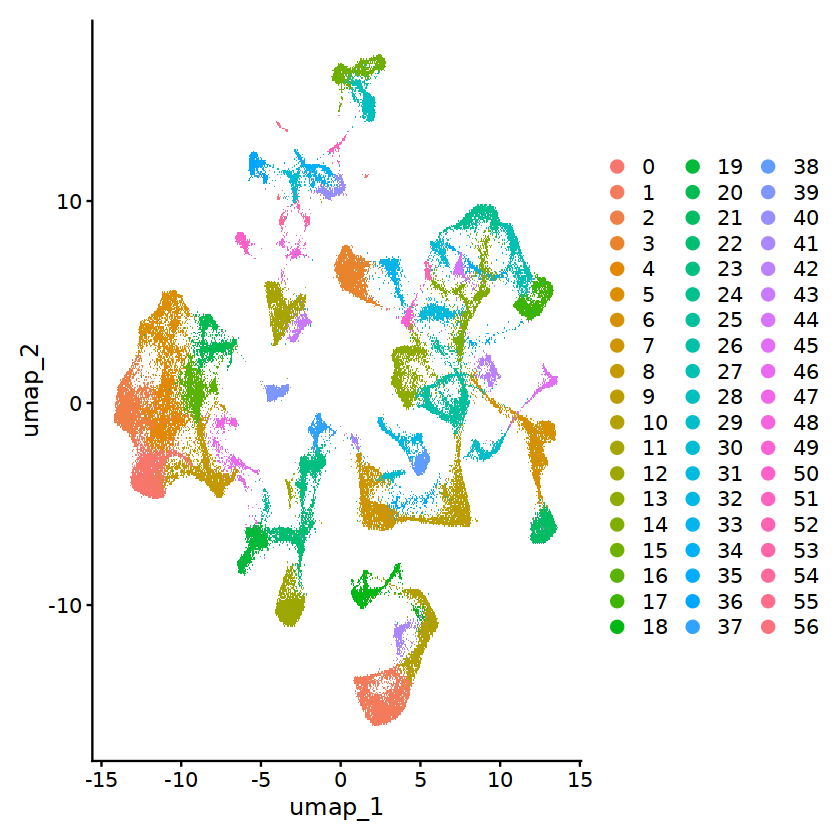

In [4]:
DimPlot(obj_neuron)

In [5]:
obj_other = qs::qread('_targets/objects/obj_other') %>%
             set_labels_to_lvl1 %>%
             #set_batch_to_lane %>% # do not set batch to lane for cluster splits
             prep_obj_for_milo_cb_v01 
obj_other

An object of class Seurat 
25033 features across 29782 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 2 layers present: data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

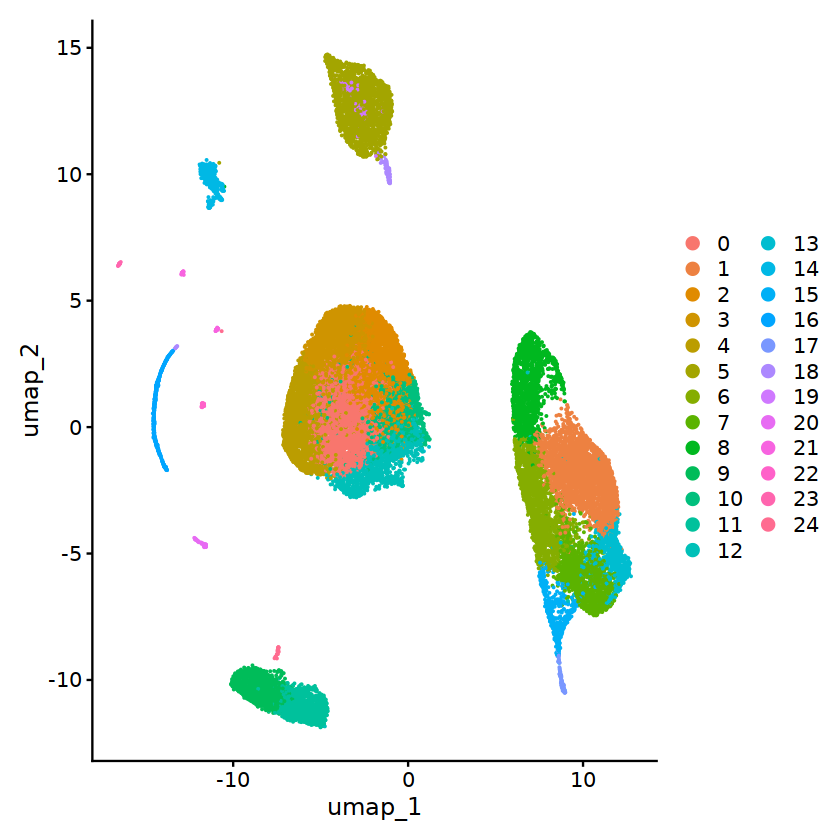

In [6]:
DimPlot(obj_other)

In [7]:
labels_classes_tib = (obj_other@meta.data %>% mutate(labels = labels_chunk) %>% select(labels) %>% mutate(class = 'other') %>% tibble %>% distinct(labels, class)) %>%
bind_rows(obj_neuron@meta.data %>% mutate(labels = labels_chunk) %>% mutate(class = 'neuron') %>% tibble %>% distinct(labels, class)) %>%
mutate(labels = str_replace(labels, fixed('-'), '__'))


In [8]:
umap_coords_neuron = obj_neuron %>%
`@`('reductions') %>%
`$`('umap') %>%
`@`('cell.embeddings') %>%
as.data.frame %>%
rownames_to_column('cell_barcode')

umap_coords_neuron %>% head

,cell_barcode,umap_1,umap_2
,<chr>,<dbl>,<dbl>
1,SI-TT-A11_AAACCCAAGGTGGTTG,1.060039,-9.89935829
2,SI-TT-A11_AAACCCACATACAGCT,4.324369,1.16208909
3,SI-TT-A11_AAACCCACATGAGGGT,4.696438,-3.14927985
4,SI-TT-A11_AAACCCAGTACGTTCA,1.344125,-13.86531212
5,SI-TT-A11_AAACCCATCCAAGCAT,-5.445605,12.35118530
6,SI-TT-A11_AAACCCATCCCATAAG,-9.186716,0.09222025


In [9]:
umap_coords_other = obj_other %>%
`@`('reductions') %>%
`$`('umap') %>%
`@`('cell.embeddings') %>%
as.data.frame %>%
rownames_to_column('cell_barcode')

umap_coords_other %>% head

,cell_barcode,umap_1,umap_2
,<chr>,<dbl>,<dbl>
1,SI-TT-A11_AAACCCAGTATCGGTT,9.741567,-6.3410525
2,SI-TT-A11_AAACGAAAGGTTCTTG,-8.439921,-10.6500720
3,SI-TT-A11_AAACGAACAAGGAGTC,-3.407435,-0.5645014
4,SI-TT-A11_AAACGAACAGCCTTCT,-4.795028,1.1611348
5,SI-TT-A11_AAACGCTAGTGCTAGG,12.090093,-5.6987538
6,SI-TT-A11_AAAGGATTCAACCCGG,8.568621,-2.9679698


In [10]:
ambiguous_cells = intersect(umap_coords_neuron %>% pull(cell_barcode), umap_coords_other %>% pull(cell_barcode))
ambiguous_cells %>% length

[1] 0

In [11]:
umap_coords_neuron = umap_coords_neuron %>% filter(!(cell_barcode %in% ambiguous_cells))
umap_coords_other = umap_coords_other %>% filter(!(cell_barcode %in% ambiguous_cells))
umap_coords = bind_rows(umap_coords_neuron, umap_coords_other)
umap_coords %>% dim

[1] 134369      3

In [12]:
# da_results_restored = qs::qread('_targets/objects/combined_da_results_nhg_all.obob5v5__v__all.obobBL6')
da_results_restored = qs::qread('_targets/objects/combined_da_results_nhg_Day5.obob5v5__v__Day5.obobBL6d5')
# column_to_rownames('hash.mcl.ID')

dim(da_results_restored)
da_results_restored %>% head

[1] 13191    18

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,comparison,restored,exact_grouping,restored_grouping,fgf1_grouping,bl6_grouping,hash.mcl.ID,n_cells
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,3.786202,13.32846,28.65605,1.203665e-05,0.002250854,127,0.002451558,pos,Agrp,1,Day5.obob5v5__v__Day5.obobBL6d5,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-E10_GCAGGCTGTGGACAGT,89
2,2.942268,13.13703,22.75446,5.730611e-05,0.003109848,18,0.003257913,pos,Agrp,1,Day5.obob5v5__v__Day5.obobBL6d5,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-C11_GTGTAACTCTTCCCGA,85
3,3.762935,13.18959,23.36177,4.837156e-05,0.003109848,19,0.003257913,pos,Agrp,1,Day5.obob5v5__v__Day5.obobBL6d5,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-H10_ACATCGACAAGACTGG,80
4,3.207390,13.03162,21.31327,8.646514e-05,0.003109848,41,0.003257913,pos,Agrp,1,Day5.obob5v5__v__Day5.obobBL6d5,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-C12_GTTGAACAGTAGTCTC,79
5,2.281578,12.96570,21.49272,8.208911e-05,0.003109848,90,0.003257913,pos,Agrp,1,Day5.obob5v5__v__Day5.obobBL6d5,FALSE,pos_FGF1,pos_FGF1,pos,none,SI-TT-E11_TTGTGTTGTTACGATC,80
6,4.542154,13.16189,22.97615,9.978122e-05,0.003109848,144,0.003257913,pos,Agrp,1,Day5.obob5v5__v__Day5.obobBL6d5,TRUE,pos_restored,pos_restored,pos,neg,SI-TT-A11_TTCTAGTGTGGAAATT,76


In [13]:
# da_results_bl6 = qs::qread('_targets/objects/combined_da_results_idx_all.obobBL6') %>%
da_results_bl6 = qs::qread('_targets/objects/combined_da_results_idx_Day5.obobBL6d5') %>%
rename(n_cells = n_cells.x) %>%
select(-n_cells.y) %>%
mutate(polarity = case_when(polarity == 'none' ~ 'none',
                            polarity == 'pos' ~ 'neg',
                            polarity == 'neg' ~ 'pos')) %>%
mutate(logFC = -logFC)


dim(da_results_bl6)
da_results_bl6 %>% head

[1] 13191    12

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,n_cells,hash.mcl.ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,8.664499,13.47266,366.3092,2.235582e-12,4.180538e-10,32,2.446212e-10,pos,Agrp,1,92,SI-TT-A12_TGATGCAGTGCTGATT
2,8.004429,12.98563,159.7132,1.608347e-11,9.960091e-10,30,7.224227e-10,pos,Agrp,1,63,SI-TT-A11_CATCGTCCAAGTGATA
3,8.548313,13.37556,285.4091,1.480124e-11,9.960091e-10,103,7.224227e-10,pos,Agrp,1,86,SI-TT-G10_GGCACGTAGCCTGACC
4,7.256882,13.18602,155.1263,2.130501e-11,9.960091e-10,57,8.031479e-10,pos,Agrp,1,75,SI-TT-H10_GTAATCGTCTCGACCT
5,7.109636,13.02557,139.3101,5.962089e-11,1.164549e-09,55,9.548138e-10,pos,Agrp,1,66,SI-TT-E11_GCTACCTCATCCGATA
6,7.104301,13.02050,137.2741,6.856719e-11,1.164549e-09,83,9.548138e-10,pos,Agrp,1,66,SI-TT-C11_CCTCATGAGGTCGTGA


In [14]:
da_results_fgf1 = qs::qread('_targets/objects/combined_da_results_idx_Day5.obob5v5') %>%
rename(n_cells = n_cells.x) %>%
select(-n_cells.y)


dim(da_results_fgf1)
da_results_fgf1 %>% head

[1] 13191    12

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,n_cells,hash.mcl.ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,3.786202,13.32846,28.65605,1.203665e-05,0.002250854,127,0.002451558,pos,Agrp,1,89,SI-TT-E10_GCAGGCTGTGGACAGT
2,2.942268,13.13703,22.75446,5.730611e-05,0.003109848,18,0.003257913,pos,Agrp,1,85,SI-TT-C11_GTGTAACTCTTCCCGA
3,3.762935,13.18959,23.36177,4.837156e-05,0.003109848,19,0.003257913,pos,Agrp,1,80,SI-TT-H10_ACATCGACAAGACTGG
4,3.207390,13.03162,21.31327,8.646514e-05,0.003109848,41,0.003257913,pos,Agrp,1,79,SI-TT-C12_GTTGAACAGTAGTCTC
5,2.281578,12.96570,21.49272,8.208911e-05,0.003109848,90,0.003257913,pos,Agrp,1,80,SI-TT-E11_TTGTGTTGTTACGATC
6,4.542154,13.16189,22.97615,9.978122e-05,0.003109848,144,0.003257913,pos,Agrp,1,76,SI-TT-A11_TTCTAGTGTGGAAATT


In [15]:
da_results_2 = full_join(da_results_fgf1, da_results_bl6, by=c('Nhood', 'labels'), suffix = c('_fgf1', '_bl6'))
da_results_2 %>% head

,logFC_fgf1,logCPM_fgf1,F_fgf1,PValue_fgf1,FDR_fgf1,Nhood,SpatialFDR_fgf1,polarity_fgf1,labels,labels_fraction_fgf1,⋯,logFC_bl6,logCPM_bl6,F_bl6,PValue_bl6,FDR_bl6,SpatialFDR_bl6,polarity_bl6,labels_fraction_bl6,n_cells_bl6,hash.mcl.ID_bl6
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
1,3.786202,13.32846,28.65605,1.203665e-05,0.002250854,127,0.002451558,pos,Agrp,1,⋯,6.716506,13.32846,98.9882688,1.691103e-10,1.756868e-09,1.521349e-09,pos,1,89,SI-TT-E10_GCAGGCTGTGGACAGT
2,2.942268,13.13703,22.75446,5.730611e-05,0.003109848,18,0.003257913,pos,Agrp,1,⋯,3.192094,13.13703,18.4248083,2.056099e-04,5.340146e-04,4.726740e-04,pos,1,85,SI-TT-C11_GTGTAACTCTTCCCGA
3,3.762935,13.18959,23.36177,4.837156e-05,0.003109848,19,0.003257913,pos,Agrp,1,⋯,6.461479,13.18959,74.0789103,3.367667e-09,1.880265e-08,1.715807e-08,pos,1,80,SI-TT-H10_ACATCGACAAGACTGG
4,3.207390,13.03162,21.31327,8.646514e-05,0.003109848,41,0.003257913,pos,Agrp,1,⋯,3.153802,13.03162,12.4463870,1.529748e-03,2.466059e-03,2.251006e-03,pos,1,79,SI-TT-C12_GTTGAACAGTAGTCTC
5,2.281578,12.96570,21.49272,8.208911e-05,0.003109848,90,0.003257913,pos,Agrp,1,⋯,-1.020584,12.96570,0.9013692,3.508883e-01,3.645340e-01,3.606322e-01,none,1,80,SI-TT-E11_TTGTGTTGTTACGATC
6,4.542154,13.16189,22.97615,9.978122e-05,0.003109848,144,0.003257913,pos,Agrp,1,⋯,8.146953,13.16189,97.0751771,2.718156e-09,1.588422e-08,1.451895e-08,pos,1,76,SI-TT-A11_TTCTAGTGTGGAAATT


In [16]:
da_results = da_results_restored %>% full_join(da_results_2, by=c('Nhood', 'labels')) %>%
mutate(exact_grouping = case_when(is.na(exact_grouping) & (polarity_bl6 != 'none') ~ paste0(polarity_bl6, '_BL6'),
                                  is.na(exact_grouping) & (polarity_bl6 == 'none') ~ paste0(polarity_bl6),
                                  TRUE ~ exact_grouping)) %>%
mutate(n_cells = n_cells_fgf1) %>%
left_join(labels_classes_tib, by='labels') %>%
mutate(cell_barcode = hash.mcl.ID_fgf1) %>%
relocate(cell_barcode, .after='hash.mcl.ID') %>%
select(-all_of(c("hash.mcl.ID", "hash.mcl.ID_fgf1", "hash.mcl.ID_bl6"))) %>%
left_join(umap_coords, by='cell_barcode') %>%
mutate(polarity_bl6 = case_when(logFC_bl6 > 0 & SpatialFDR_bl6 < 0.1 ~ 'pos',
                                logFC_bl6 < 0 & SpatialFDR_bl6 < 0.1 ~ 'neg',
                                TRUE ~ 'none')) %>%
mutate(polarity_fgf1 = case_when(logFC_fgf1 > 0 & SpatialFDR_fgf1 < 0.1 ~ 'pos',
                                logFC_fgf1 < 0 & SpatialFDR_fgf1 < 0.1 ~ 'neg',
                                TRUE ~ 'none'))

da_results %>% dim
da_results %>% head

[1] 13191    39

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,polarity,labels,labels_fraction,⋯,F_bl6,PValue_bl6,FDR_bl6,SpatialFDR_bl6,polarity_bl6,labels_fraction_bl6,n_cells_bl6,class,umap_1,umap_2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,3.786202,13.32846,28.65605,1.203665e-05,0.002250854,127,0.002451558,pos,Agrp,1,⋯,98.9882688,1.691103e-10,1.756868e-09,1.521349e-09,pos,1,89,NA,3.216700,-13.25480
2,2.942268,13.13703,22.75446,5.730611e-05,0.003109848,18,0.003257913,pos,Agrp,1,⋯,18.4248083,2.056099e-04,5.340146e-04,4.726740e-04,pos,1,85,NA,3.556380,-13.47460
3,3.762935,13.18959,23.36177,4.837156e-05,0.003109848,19,0.003257913,pos,Agrp,1,⋯,74.0789103,3.367667e-09,1.880265e-08,1.715807e-08,pos,1,80,NA,3.986626,-12.99642
4,3.207390,13.03162,21.31327,8.646514e-05,0.003109848,41,0.003257913,pos,Agrp,1,⋯,12.4463870,1.529748e-03,2.466059e-03,2.251006e-03,pos,1,79,NA,3.500047,-14.23880
5,2.281578,12.96570,21.49272,8.208911e-05,0.003109848,90,0.003257913,pos,Agrp,1,⋯,0.9013692,3.508883e-01,3.645340e-01,3.606322e-01,none,1,80,NA,3.647344,-14.31736
6,4.542154,13.16189,22.97615,9.978122e-05,0.003109848,144,0.003257913,pos,Agrp,1,⋯,97.0751771,2.718156e-09,1.588422e-08,1.451895e-08,pos,1,76,NA,2.933367,-13.35223


In [17]:
da_results_restored %>% distinct(labels) %>% pull(labels)

[1] "Agrp"                "Arx__Nr5a2"          "Astrocytes"         
 [4] "Dlk1"                "Endothelial_cells"   "Ependymal_cells"    
 [7] "Esr1"                "Fez1"                "g_drop"             
[10] "g1"                  "g2"                  "g3"                 
[13] "g4"                  "Ghrh"                "Gpr50__Tac2"        
[16] "Hdc"                 "Htr3b"               "Irx5__Lmx1a"        
[19] "Kiss1__Tac2"         "Lepr15"              "Lepr67"             
[22] "Lepr89"              "Lpar1_oligo"         "Met__Pappa2"        
[25] "Met__Prlh"           "Microglia"           "n_drop"             
[28] "n0"                  "n1"                  "n2"                 
[31] "n3"                  "n4"                  "n5"                 
[34] "n6"                  "n8"                  "neuron"             
[37] "Nfib_1"              "Nfib_2"              "Nfib_3"             
[40] "Nfix__Nfib"          "Nfix__Nfib__Hgf"     "Nfix__Nfib__Lhx6"   
[43] "Npsr1__Epha3"        "Oligodendrocytes"    "OPC"                
[46] "other"               "Pomc__Anxa2"         "Pomc__Glipr1"       
[49] "Pomc__Ttr"           "Pou6f2__Prkcq__Whrn" "Ppp1r17"            
[52] "Ppp1r17__Ltbp1"      "Ppp1r17__Tafa4"      "Reln__Lef1"         
[55] "Sim1"                "Slc17a6__Trhr"       "Sst__Nts"           
[58] "Sst__Pthlh"          "Sst__Unc13c"         "Tanycytes"          
[61] "Tbx19__Pirt"         "Th__Nfib"            "Th__Slc6a3"         
[64] "Tmem215__Dach2"      "Tmem215__Greb1"      "Trh__Cxcl12"        
[67] "Trh__Lef1"

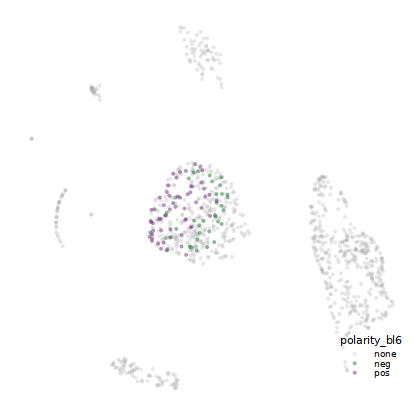

In [18]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
umap_bl6_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity_bl6 = factor(polarity_bl6, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_bl6) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_bl6, alpha=polarity_bl6)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#1b7837",
                              'pos' = "#762a83")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_bl6_other 

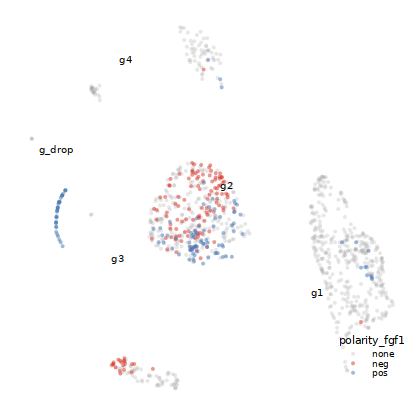

In [19]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
label_data <- da_results %>%
  filter(class == 'other') %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_fgf1_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity_fgf1 = factor(polarity_fgf1, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_fgf1) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_fgf1, alpha=polarity_fgf1)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#d73027",
                              'pos' = "#4575b4")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(1, "lines"), 
              point.padding = unit(2, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))


umap_fgf1_other 

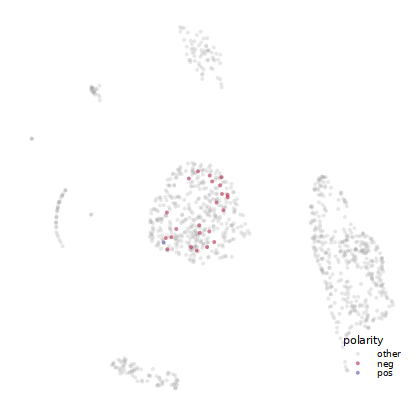

In [20]:
options(repr.plot.width=3.5, repr.plot.height=3.5)
umap_restored_other = da_results %>%
filter(class == 'other') %>%
mutate(polarity = case_when(exact_grouping == 'pos_restored' ~ "pos",
                             exact_grouping == 'neg_restored' ~ "neg",
                             TRUE ~ 'other')) %>%
mutate(polarity = factor(polarity, levels = c("other", "neg", "pos"))) %>%
arrange(polarity) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity, alpha=polarity)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('other' =  "#a1a1a1",
                              'neg' = "#a50026",
                              'pos' = "#313695")) +
scale_alpha_manual(values = c("other" = 0.25, "neg" = 0.5, "pos"=0.5)) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_restored_other 

In [21]:
all_restored_summary = qs::qread('_targets/objects/all_restored_summary') %>%
filter(comparison == 'Day5.obob5v5__v__Day5.obobBL6d5') %>%
mutate(prop_fgf1 = n_fgf1/n_total) %>%
mutate(prop_BL6 = n_BL6/n_total) %>%
mutate(prop_sum = prop_fgf1 + prop_BL6) %>%
mutate(n_sum = n_fgf1 + n_BL6) %>%
arrange(desc(n_fgf1))

all_restored_summary %>% head

label_order = all_restored_summary %>% pull(labels)
label_order

labels,n_total,n_fgf1,n_fgf1.pos,n_fgf1.neg,prop_fgf1.pos,n_BL6,n_restored,n_restored.pos,n_restored.neg,prop_restored_BL6,prop_restored_FGF1,comparison,prop_fgf1,prop_BL6,prop_sum,n_sum
<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
other,855,325,139,186,0.4276923,4,4,4,0,1.0000000,0.01230769,Day5.obob5v5__v__Day5.obobBL6d5,0.3801170,0.004678363,0.3847953,329
Astrocytes,441,190,80,110,0.4210526,129,30,2,28,0.2325581,0.15789474,Day5.obob5v5__v__Day5.obobBL6d5,0.4308390,0.292517007,0.7233560,319
g2,424,182,75,107,0.4120879,94,24,1,23,0.2553191,0.13186813,Day5.obob5v5__v__Day5.obobBL6d5,0.4292453,0.221698113,0.6509434,276
n1,392,82,31,51,0.3780488,201,58,8,50,0.2885572,0.70731707,Day5.obob5v5__v__Day5.obobBL6d5,0.2091837,0.512755102,0.7219388,283
Htr3b,142,77,42,35,0.5454545,3,3,3,0,1.0000000,0.03896104,Day5.obob5v5__v__Day5.obobBL6d5,0.5422535,0.021126761,0.5633803,80
OPC,97,58,27,31,0.4655172,0,0,0,0,NaN,0.00000000,Day5.obob5v5__v__Day5.obobBL6d5,0.5979381,0.000000000,0.5979381,58


[1] "other"               "Astrocytes"          "g2"                 
 [4] "n1"                  "Htr3b"               "OPC"                
 [7] "g3"                  "Agrp"                "Trh__Lef1"          
[10] "Tanycytes"           "n0"                  "Oligodendrocytes"   
[13] "g1"                  "Ghrh"                "Ppp1r17__Tafa4"     
[16] "Ependymal_cells"     "Sst__Unc13c"         "Tbx19__Pirt"        
[19] "Irx5__Lmx1a"         "Kiss1__Tac2"         "Pomc__Glipr1"       
[22] "Pou6f2__Prkcq__Whrn" "Sst__Pthlh"          "n8"                 
[25] "Th__Slc6a3"          "neuron"              "Arx__Nr5a2"         
[28] "Dlk1"                "Endothelial_cells"   "Esr1"               
[31] "Fez1"                "Gpr50__Tac2"         "Hdc"                
[34] "Lepr15"              "Lepr67"              "Lepr89"             
[37] "Lpar1_oligo"         "Met__Pappa2"         "Met__Prlh"          
[40] "Microglia"           "Nfib_1"              "Nfib_2"             
[43] "Nfib_3"              "Nfix__Nfib"          "Nfix__Nfib__Hgf"    
[46] "Nfix__Nfib__Lhx6"    "Npsr1__Epha3"        "Pomc__Anxa2"        
[49] "Pomc__Ttr"           "Ppp1r17"             "Ppp1r17__Ltbp1"     
[52] "Reln__Lef1"          "Sim1"                "Slc17a6__Trhr"      
[55] "Sst__Nts"            "Th__Nfib"            "Tmem215__Dach2"     
[58] "Tmem215__Greb1"      "Trh__Cxcl12"         "g4"                 
[61] "g_drop"              "n2"                  "n3"                 
[64] "n4"                  "n5"                  "n6"                 
[67] "n_drop"

In [22]:
all_restored_summary %>% filter(prop_sum > 0) %>%
left_join(labels_classes_tib, by='labels') %>%
group_by(class) %>% summarise(n=n())

class,n
<chr>,<int>
neuron,6
other,3
NA,31


In [23]:
all_restored_summary %>%
left_join(labels_classes_tib, by='labels') %>%
filter(class=='neuron') %>%
arrange(desc(n_sum)) %>%
head(20)

labels,n_total,n_fgf1,n_fgf1.pos,n_fgf1.neg,prop_fgf1.pos,n_BL6,n_restored,n_restored.pos,n_restored.neg,prop_restored_BL6,prop_restored_FGF1,comparison,prop_fgf1,prop_BL6,prop_sum,n_sum,class
<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>
n1,392,82,31,51,0.3780488,201,58,8,50,0.28855721,0.7073171,Day5.obob5v5__v__Day5.obobBL6d5,0.20918367,0.512755102,0.72193878,283,neuron
n0,1405,16,11,5,0.6875000,26,1,1,0,0.03846154,0.0625000,Day5.obob5v5__v__Day5.obobBL6d5,0.01138790,0.018505338,0.02989324,42,neuron
n2,416,0,NA,NA,NA,39,0,0,0,0.00000000,NaN,Day5.obob5v5__v__Day5.obobBL6d5,0.00000000,0.093750000,0.09375000,39,neuron
n5,146,0,NA,NA,NA,11,0,0,0,0.00000000,NaN,Day5.obob5v5__v__Day5.obobBL6d5,0.00000000,0.075342466,0.07534247,11,neuron
n3,34,0,NA,NA,NA,7,0,0,0,0.00000000,NaN,Day5.obob5v5__v__Day5.obobBL6d5,0.00000000,0.205882353,0.20588235,7,neuron
n8,167,2,2,NA,1.0000000,1,1,1,0,1.00000000,0.5000000,Day5.obob5v5__v__Day5.obobBL6d5,0.01197605,0.005988024,0.01796407,3,neuron
n4,903,0,NA,NA,NA,0,0,0,0,NaN,NaN,Day5.obob5v5__v__Day5.obobBL6d5,0.00000000,0.000000000,0.00000000,0,neuron
n6,62,0,NA,NA,NA,0,0,0,0,NaN,NaN,Day5.obob5v5__v__Day5.obobBL6d5,0.00000000,0.000000000,0.00000000,0,neuron
n_drop,219,0,NA,NA,NA,0,0,0,0,NaN,NaN,Day5.obob5v5__v__Day5.obobBL6d5,0.00000000,0.000000000,0.00000000,0,neuron


In [24]:
unchanged_labels = all_restored_summary %>%
filter(!(prop_sum > 0)) %>%
pull(labels)
unchanged_labels

[1] "Dlk1"              "Endothelial_cells" "Esr1"             
 [4] "Fez1"              "Gpr50__Tac2"       "Hdc"              
 [7] "Lepr15"            "Lepr67"            "Lepr89"           
[10] "Met__Pappa2"       "Microglia"         "Nfib_1"           
[13] "Nfib_2"            "Nfib_3"            "Nfix__Nfib"       
[16] "Npsr1__Epha3"      "Ppp1r17"           "Ppp1r17__Ltbp1"   
[19] "Reln__Lef1"        "Sim1"              "Slc17a6__Trhr"    
[22] "Sst__Nts"          "g4"                "g_drop"           
[25] "n4"                "n6"                "n_drop"

In [25]:
all_restored_summary %>%
filter(str_detect(labels, 'Ghrh'))

labels,n_total,n_fgf1,n_fgf1.pos,n_fgf1.neg,prop_fgf1.pos,n_BL6,n_restored,n_restored.pos,n_restored.neg,prop_restored_BL6,prop_restored_FGF1,comparison,prop_fgf1,prop_BL6,prop_sum,n_sum
<chr>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
Ghrh,70,7,3,4,0.4285714,35,7,3,4,0.2,1,Day5.obob5v5__v__Day5.obobBL6d5,0.1,0.5,0.6,42


In [26]:
beeswarm_tibble = da_results %>%
select(Nhood, labels, class, n_cells, polarity_fgf1, SpatialFDR_fgf1, logFC_fgf1, polarity_bl6, SpatialFDR_bl6, logFC_bl6, exact_grouping) %>%
mutate(restored = case_when(exact_grouping == 'pos_restored' ~ 'yes',
                             exact_grouping == 'neg_restored' ~ 'yes',
                             TRUE ~ 'no')) %>%
mutate(restored = factor(restored, levels=c('no', 'yes')))

# Separate data frames for each type of measurement
polarity_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("polarity"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("polarity"),
               names_to = "comparison",
               values_to = "polarity") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

spatial_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("SpatialFDR"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("SpatialFDR"),
               names_to = "comparison",
               values_to = "SpatialFDR") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

logfc_df <- beeswarm_tibble %>%
  select(Nhood, labels, class, n_cells, starts_with("logFC"), exact_grouping, restored) %>%
  pivot_longer(cols = starts_with("logFC"),
               names_to = "comparison",
               values_to = "logFC") %>%
  mutate(comparison = ifelse(str_detect(comparison, "bl6"), "BL6", "FGF1"))

# Join all dataframes
beeswarm_tibble <- polarity_df %>%
  inner_join(spatial_df, by = c("Nhood", "labels", "class", "n_cells", "comparison", "exact_grouping", "restored")) %>%
  inner_join(logfc_df, by = c("Nhood", "labels", "class", "n_cells", "comparison", "exact_grouping", "restored"))


beeswarm_tibble = beeswarm_tibble %>%
mutate(labels = factor(labels, levels=rev(label_order))) %>%
rowwise %>%
mutate(label.group = paste0(labels, '.', comparison)) %>% 
ungroup %>%
mutate(polarity = paste0(polarity, '.', comparison)) %>%
mutate(polarity = case_when(str_detect(polarity, 'none') ~ 'none',
                            TRUE ~ polarity)) %>%
mutate(polarity = factor(polarity, levels=rev(c('none', 'neg.BL6', 'pos.BL6', 'neg.FGF1', 'pos.FGF1')))) %>%
arrange(desc(labels))

beeswarm_tibble

Nhood,labels,class,n_cells,exact_grouping,restored,comparison,polarity,SpatialFDR,logFC,label.group
<dbl>,<fct>,<chr>,<dbl>,<chr>,<fct>,<chr>,<fct>,<dbl>,<dbl>,<chr>
386,other,NA,80,pos_FGF1,no,FGF1,pos.FGF1,5.913861e-07,5.7880850,other.FGF1
386,other,NA,80,pos_FGF1,no,BL6,none,9.587951e-01,0.3291051,other.BL6
822,other,NA,70,pos_FGF1,no,FGF1,pos.FGF1,5.913861e-07,6.6390950,other.FGF1
822,other,NA,70,pos_FGF1,no,BL6,none,7.890363e-01,1.3817936,other.BL6
464,other,NA,72,pos_FGF1,no,FGF1,pos.FGF1,8.770765e-07,5.0318362,other.FGF1
464,other,NA,72,pos_FGF1,no,BL6,none,9.607907e-01,-0.2793494,other.BL6
263,other,NA,70,pos_FGF1,no,FGF1,pos.FGF1,1.180133e-06,4.9838278,other.FGF1
263,other,NA,70,pos_FGF1,no,BL6,none,9.597985e-01,-0.2828503,other.BL6
199,other,NA,65,pos_FGF1,no,FGF1,pos.FGF1,1.274122e-06,4.8487326,other.FGF1


In [27]:
beeswarm_tibble %>% head %>% print

# A tibble: 6 × 11
  Nhood labels class n_cells exact_grouping restored comparison polarity
  <dbl> <fct>  <chr>   <dbl> <chr>          <fct>    <chr>      <fct>   
1   386 other  NA         80 pos_FGF1       no       FGF1       pos.FGF1
2   386 other  NA         80 pos_FGF1       no       BL6        none    
3   822 other  NA         70 pos_FGF1       no       FGF1       pos.FGF1
4   822 other  NA         70 pos_FGF1       no       BL6        none    
5   464 other  NA         72 pos_FGF1       no       FGF1       pos.FGF1
6   464 other  NA         72 pos_FGF1       no       BL6        none    
# ℹ 3 more variables: SpatialFDR <dbl>, logFC <dbl>, label.group <chr>


In [28]:
beeswarm_tibble %>% pull(polarity) %>% unique
beeswarm_tibble %>% pull(polarity) %>% levels

[1] pos.FGF1 none     neg.FGF1 pos.BL6  neg.BL6 
Levels: pos.FGF1 neg.FGF1 pos.BL6 neg.BL6 none

[1] "pos.FGF1" "neg.FGF1" "pos.BL6"  "neg.BL6"  "none"

In [29]:
beeswarm_tibble %>% filter(restored == 'yes') %>% dim

[1] 382  11

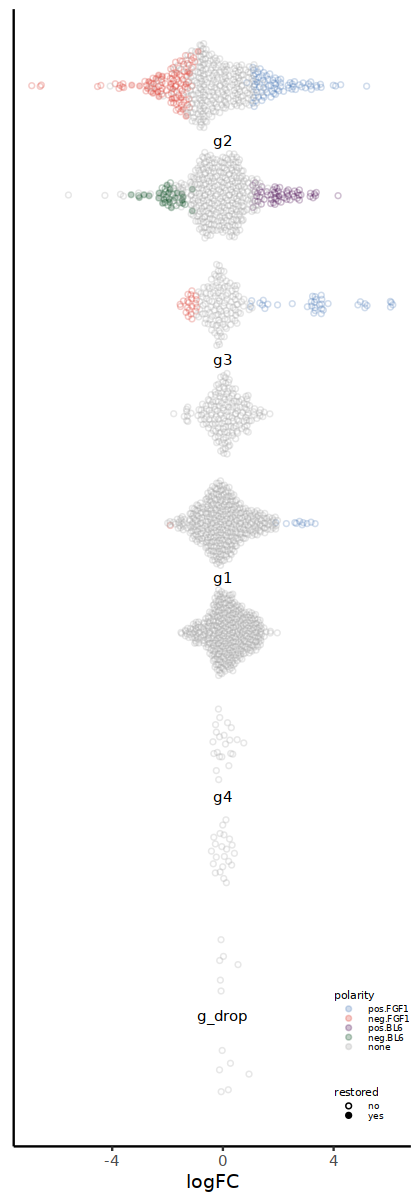

In [30]:
options(repr.plot.width=3.5, repr.plot.height=10)

# Creating a separate tibble for the labels
label_tibble <- beeswarm_tibble %>%
  filter(class == 'other')  %>%
#   filter(!(labels %in% unchanged_labels)) %>%
  distinct(labels)

beeswarm_other = beeswarm_tibble %>%
  filter(class == 'other') %>%
#   filter(!(labels %in% unchanged_labels)) %>%
  arrange(labels, polarity, restored) %>%
  ggplot(aes(logFC, labels, group=comparison, color=polarity, alpha=polarity, shape=restored)) + 
  geom_quasirandom(size=1, dodge.width = 1, orientation='y') +
  scale_shape_manual(values = c(yes=19, no=1)) +
  scale_color_manual(values = c('none' =  "#a1a1a1",
                                'neg.FGF1' = "#d73027",
                                'pos.FGF1' = "#4575b4",
                                'neg.BL6' = "#00441b",
                                'pos.BL6' = "#40004b")) + 
  scale_alpha_manual(values = c('none' =  0.25,
                                'neg.FGF1' = 0.25,
                                'pos.FGF1' = 0.25,
                                'neg.BL6' = 0.25,
                                'pos.BL6' = 0.25)) +
  geom_text(data = label_tibble, aes(x = 0, y = labels, label = labels), size=3, hjust = 0.5, vjust = 0.5, inherit.aes = FALSE) +
  theme_classic() +
  theme(axis.title.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.y = element_blank())  + 
theme(legend.position=c(0.9,0.08)) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))
beeswarm_other

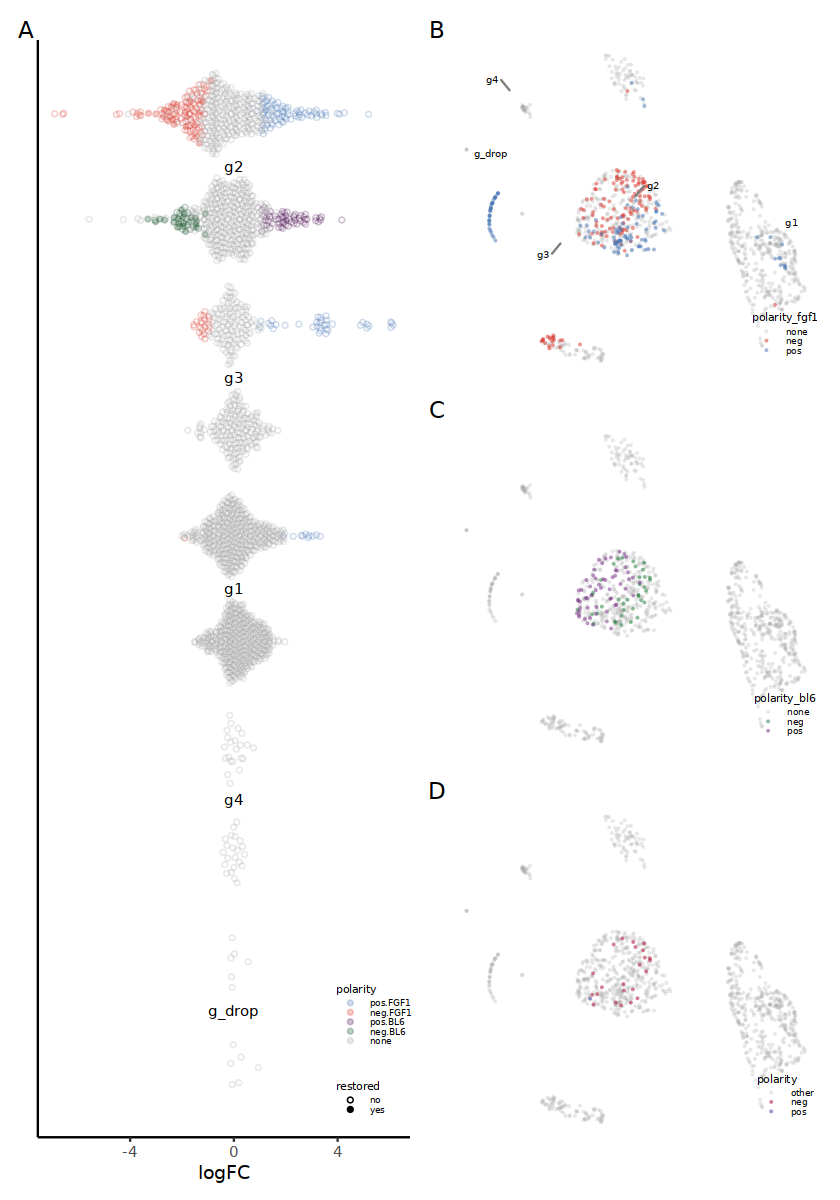

In [31]:
options(repr.plot.width=7, repr.plot.height=10)
layout <- '
AB
AC
AD
'

ggp = wrap_plots(A = beeswarm_other,
           B = umap_fgf1_other,
           C = umap_bl6_other,
           D = umap_restored_other,
    design = layout) +
plot_layout(guides = 'auto') + plot_annotation(tag_levels = c('A', 'B', 'C', 'D'))

ggp %>% ggsave('beeswarm_umap_other_d5_chunk.pdf', plot = ., width = 7, height=9)
ggp

In [32]:
unchanged_labels_bl6 = da_results %>%
group_by(labels) %>%
summarise(polarities = polarity_bl6 %>% unique) %>%
group_by(labels) %>%
summarise(n=n()) %>%
# filter(n == 1) %>%
pull(labels)

unchanged_labels_bl6

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'labels'. You can override using the
`.groups` argument.


[1] "Agrp"                "Arx__Nr5a2"          "Astrocytes"         
 [4] "Dlk1"                "Endothelial_cells"   "Ependymal_cells"    
 [7] "Esr1"                "Fez1"                "Ghrh"               
[10] "Gpr50__Tac2"         "Hdc"                 "Htr3b"              
[13] "Irx5__Lmx1a"         "Kiss1__Tac2"         "Lepr15"             
[16] "Lepr67"              "Lepr89"              "Lpar1_oligo"        
[19] "Met__Pappa2"         "Met__Prlh"           "Microglia"          
[22] "Nfib_1"              "Nfib_2"              "Nfib_3"             
[25] "Nfix__Nfib"          "Nfix__Nfib__Hgf"     "Nfix__Nfib__Lhx6"   
[28] "Npsr1__Epha3"        "OPC"                 "Oligodendrocytes"   
[31] "Pomc__Anxa2"         "Pomc__Glipr1"        "Pomc__Ttr"          
[34] "Pou6f2__Prkcq__Whrn" "Ppp1r17"             "Ppp1r17__Ltbp1"     
[37] "Ppp1r17__Tafa4"      "Reln__Lef1"          "Sim1"               
[40] "Slc17a6__Trhr"       "Sst__Nts"            "Sst__Pthlh"         
[43] "Sst__Unc13c"         "Tanycytes"           "Tbx19__Pirt"        
[46] "Th__Nfib"            "Th__Slc6a3"          "Tmem215__Dach2"     
[49] "Tmem215__Greb1"      "Trh__Cxcl12"         "Trh__Lef1"          
[52] "g1"                  "g2"                  "g3"                 
[55] "g4"                  "g_drop"              "n0"                 
[58] "n1"                  "n2"                  "n3"                 
[61] "n4"                  "n5"                  "n6"                 
[64] "n8"                  "n_drop"              "neuron"             
[67] "other"

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'labels'. You can override using the
`.groups` argument.


[1] 35

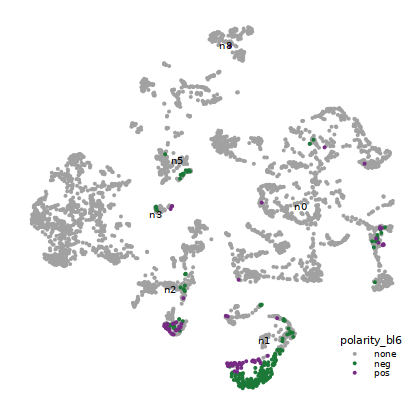

In [33]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

unchanged_labels_bl6 = da_results %>%
group_by(labels) %>%
summarise(polarities = polarity_bl6 %>% unique) %>%
group_by(labels) %>%
summarise(n=n()) %>%
filter(n == 1) %>%
pull(labels)
unchanged_labels_bl6 %>% length

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_bl6)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_bl6_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity_bl6 = factor(polarity_bl6, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_bl6) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_bl6, alpha=polarity_bl6)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#1b7837",
                              'pos' = "#762a83")) +
scale_alpha_manual(values = c("none" = 1, "neg" = 1, "pos"=1)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_bl6_neuron

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'labels'. You can override using the
`.groups` argument.


[1] 41

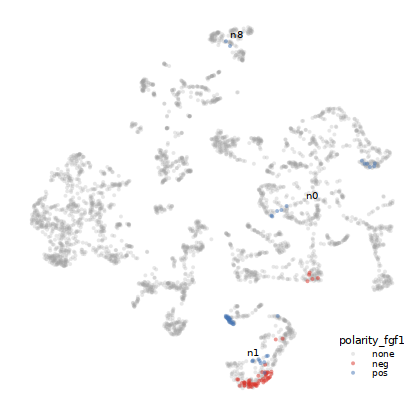

In [34]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

unchanged_labels_fgf1 = da_results %>%
group_by(labels) %>%
summarise(polarities = polarity_fgf1 %>% unique) %>%
group_by(labels) %>%
summarise(n=n()) %>%
filter(n == 1) %>%
pull(labels)
unchanged_labels_fgf1 %>% length

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_fgf1)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_fgf1_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity_fgf1 = factor(polarity_fgf1, levels = c("none", "neg", "pos"))) %>%
arrange(polarity_fgf1) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity_fgf1, alpha=polarity_fgf1)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('none' =  "#a1a1a1",
                              'neg' = "#d73027",
                              'pos' = "#4575b4")) +
scale_alpha_manual(values = c("none" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))


umap_fgf1_neuron 

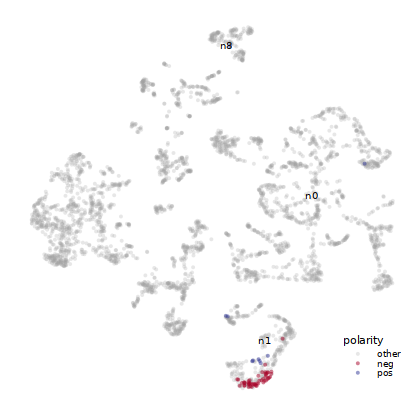

In [35]:
options(repr.plot.width=3.5, repr.plot.height=3.5)

label_data <- da_results %>%
  filter(class == 'neuron') %>%
  filter(!(labels %in% unchanged_labels_fgf1)) %>%
  filter(!(labels %in% unchanged_labels_bl6)) %>%
  mutate(labels = str_replace(labels, fixed('__'), '\n')) %>%
  group_by(labels) %>%
  summarise(umap_1 = mean(umap_1, na.rm = TRUE),
            umap_2 = mean(umap_2, na.rm =TRUE),
            label = first(labels))

umap_restored_neuron = da_results %>%
filter(class == 'neuron') %>%
mutate(polarity = case_when(exact_grouping == 'pos_restored' ~ "pos",
                             exact_grouping == 'neg_restored' ~ "neg",
                             TRUE ~ 'other')) %>%
mutate(polarity = factor(polarity, levels = c("other", "neg", "pos"))) %>%
arrange(polarity) %>%
ggplot(aes(x = umap_1, y = umap_2, color=polarity, alpha=polarity)) + 
geom_point(size=0.5, shape = 16) + 
scale_color_manual(values = c('other' =  "#a1a1a1",
                              'neg' = "#a50026",
                              'pos' = "#313695")) +
scale_alpha_manual(values = c("other" = 0.25, "neg" = 0.5, "pos"=0.5)) +
geom_text_repel(data = label_data, aes(x = umap_1, y = umap_2, label = label), 
              size = 2, 
              box.padding = unit(0, "lines"), 
              point.padding = unit(0, "lines"),
              segment.color = 'grey50',
              inherit.aes = FALSE) +
theme_minimal() + theme(legend.position=c(0.9,0.125)) + theme(
  axis.ticks = element_blank(),
  panel.grid.major = element_blank(),
  panel.grid.minor = element_blank()
) + theme(
  axis.text = element_blank(),
  axis.title.x = element_blank(),
  axis.text.x = element_blank(),
  axis.text.y = element_blank(),
  axis.title.y = element_blank()
) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

umap_restored_neuron 

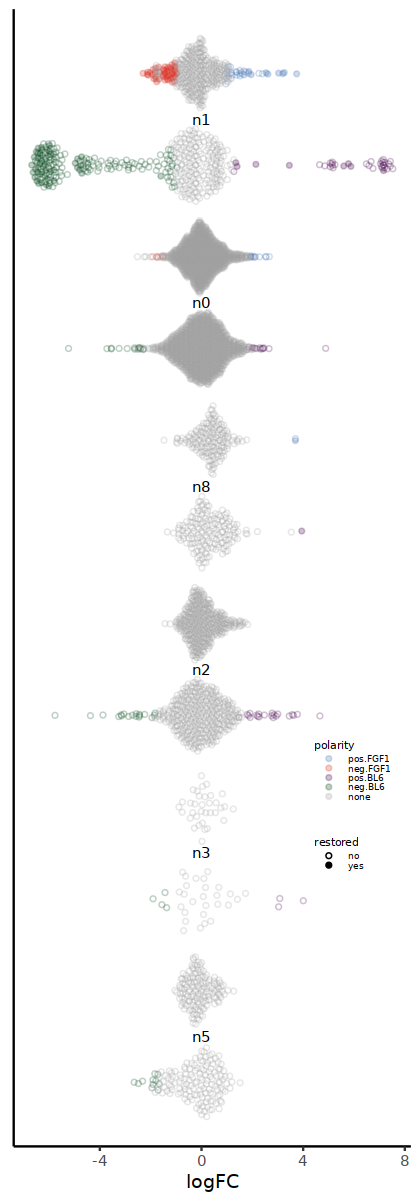

In [36]:
options(repr.plot.width=3.5, repr.plot.height=10)

# Creating a separate tibble for the labels
label_tibble <- da_results %>%
  filter(class == 'neuron') %>%
  filter((polarity_fgf1 %in% c('pos', 'neg')) | (polarity_bl6 %in% c('pos', 'neg'))) %>%
  distinct(labels)

beeswarm_neuron = beeswarm_tibble %>%
  filter(class == 'neuron') %>%
  filter((labels %in% label_tibble$labels)) %>%
  arrange(labels, polarity, restored) %>%
  ggplot(aes(logFC, labels, group=comparison, color=polarity, alpha=polarity, shape=restored)) + 
  geom_quasirandom(size=1, dodge.width = 1, orientation='y') +
  scale_shape_manual(values = c(yes=19, no=1)) +
  scale_color_manual(values = c('none' =  "#a1a1a1",
                                'neg.FGF1' = "#d73027",
                                'pos.FGF1' = "#4575b4",
                                'neg.BL6' = "#00441b",
                                'pos.BL6' = "#40004b")) + 
  scale_alpha_manual(values = c('none' =  0.25,
                                'neg.FGF1' = 0.25,
                                'pos.FGF1' = 0.25,
                                'neg.BL6' = 0.25,
                                'pos.BL6' = 0.25)) +
  geom_text(data = label_tibble, aes(x = 0, y = labels, label = labels), size=3, hjust = 0.5, vjust = 0.5, inherit.aes = FALSE) +
  theme_classic() +
  theme(axis.title.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.text.y = element_blank())  + 
theme(legend.position=c(0.85,0.3)) + 
theme(legend.text = element_text(size = 5),
      legend.title = element_text(size = 6),
      legend.key.height = unit(0.2, "cm"))

beeswarm_neuron

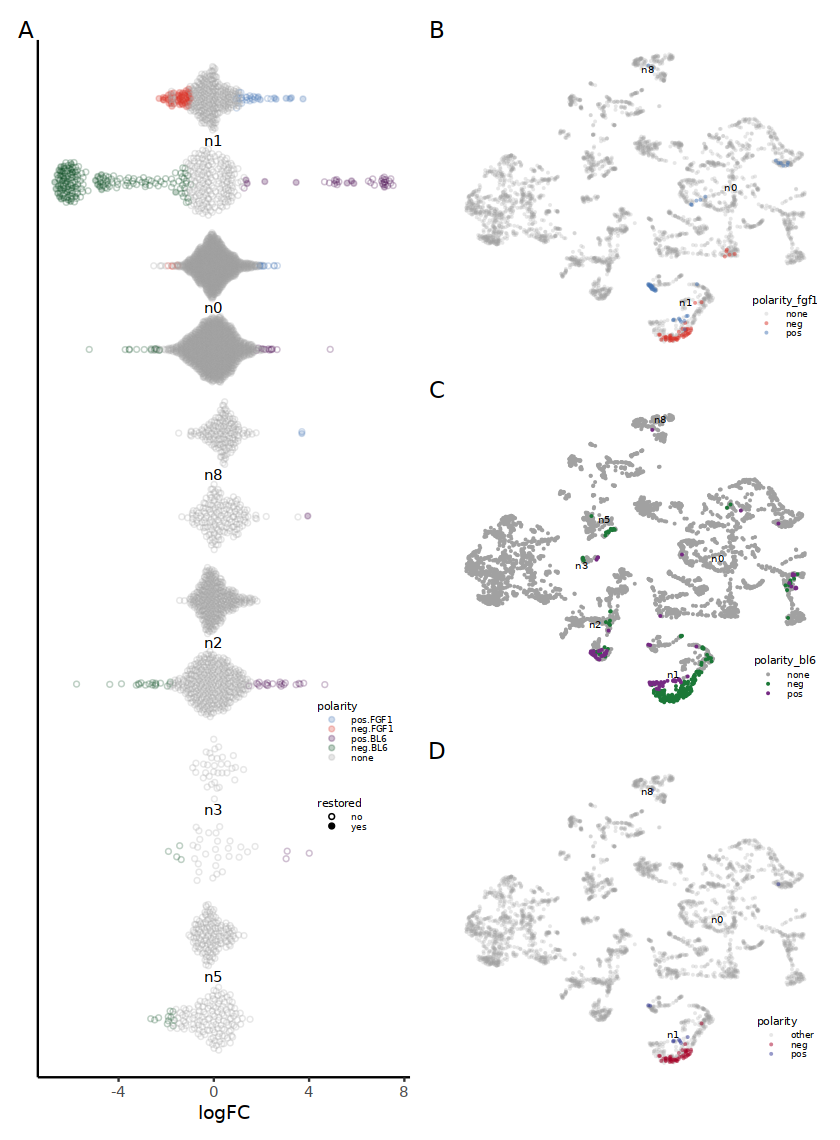

In [37]:
options(repr.plot.width=7, repr.plot.height=9.5)
layout <- '
AB
AC
AD
'

ggp = wrap_plots(A = beeswarm_neuron,
           B = umap_fgf1_neuron,
           C = umap_bl6_neuron,
           D = umap_restored_neuron,
    design = layout) +
plot_layout(guides = 'auto') + plot_annotation(tag_levels = c('A', 'B', 'C', 'D'))

ggp %>% ggsave('beeswarm_umap_neurons_d5_chunk.pdf', plot = ., width = 7, height=9)
ggp

In [38]:
beeswarm_tibble %>% qs::qsave('beeswarm_tibble_d5.qs')
da_results %>% qs::qsave('beeswarm_da_results_d5.qs')